WORKSHOP : Spatial transcriptomics 


# Introdution 

**Objectives** : 

* how to map dissociated single cells back to their tissue of origin using novoSpaRc (de novo Spatial Reconstruction of Single-Cell Gene Expression).


## Sources of inspiration

This course material is based on Novosparc tutorial:

* novosparc tutorial :reconstruct_drosophila_embryo_tutorial.ipynb



# 1- Import the library and data

## Load the libraries

The following steps are not necessary. Only execute if you do not have a local copy of the files.

In [26]:
#check the contents of the current folder 
!ls
# clone our GitHub repository 
!git clone https://github.com/PSL-winter-school-2021/02-tuesday-workshop-rna.git
%cd jupyter
#alternative : if you work on colab you can associate your notebook to a your google drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount = True)

Guest   Shared  lnoiret
fatal: could not create work tree dir '02-tuesday-workshop-rna': Permission denied


In [24]:
# To install packages (if pip3 doesn't work, try p)
!pip3 install novosparc
!pip install scanpy

In [31]:
import novosparc  # spatial transcriptome
import numpy as np      # manipulate data array
import pandas as pd
import matplotlib.pyplot as plt
import anndata as an
import scanpy as sc

## Import data 
novoSpaRc  is an algorithm that  predicts the locations of dissociated single cells. To work, the algorithm needs :

* the expression matrix of the single cells data
* the shape/geometry of the tissue of origin
* optional : marker gens : the performance is greatly increase if you provide some marker genes (also called landmarks / atlas) for which the expression patterns are known. In this tutorial we will compare the results of the reconstrucion obtained without  and with markers genes.

Path to the datafiles: 

### Single cells expression matrix


In [32]:
# Single data : expression matrix 
datafile_sc      ='data_day2/drosophila_scRNAseq/dge_nrlz_filtered.csv'
# geometry of the tissue
datafile_geom   ="data_day2/bdtnp/geometry_filtered.txt"
# Landamark genes = genes with known pattern of expression (eg. FISH image...)
datafile_atlas  ='data_day2/bdtnp/atlas.txt'

How to format the single cell matrix : 

* Novosparc expect a matrix with **genes in columns and cells in rows**. Be careful, this is not the usual order! 
* Nitizan and al. advised to use the **normalized gene expression matrix** (e.g. using the global scaling log-normalization method)
* The data need to be in the Anndata format. Novosparc has a function `novosparc.io.load_data` to import an expression matrix and to convert it the Anndata format. You can also convert a pandas dataframe to an anndata

In [33]:
data    = pd.read_csv(datafile_sc,index_col=0) 
dataset = sc.AnnData(data )

# tanspose the matrix to have gene in columns and cells in rows
dataset = dataset.T 

print ('number of cells: ',dataset.shape[0],'\nnumber of genes: ', dataset.shape[1])
print("Gene names :", dataset.var.index.tolist()[:10])


number of cells:  1297 
number of genes:  491
Gene names : ['18w', '5-HT2A', 'Abd-B', 'Act87E', 'Adgf-A', 'Aldh', 'Alh', 'Alk', 'Ama', 'Ance']


### Geometry of the tissue (*target space*)

You need to create the grid that describes the shape of your tissue (location of the cells in the tissue). 

You have 3 options :

* either 1) you know the cellular locations and have them in a file; i.e. you have a file that contain the XYZ coordinates (location) of each cells in your tissue. (If your tissue is flat, you can set the Z-coordinate to 1)
* either 2) you don't know the cellular locations, but you know the shape of your tissue;
* either 3) you know nothing and will just assume that your tissue is a rectangle.

Here we know the cellular locations : 

In [34]:
locations = novosparc.io.load_target_space(datafile_geom, is_2D=True)

print()
# Alternative : 

# case 2 : you have a black and white mask giving you the shape of your tissue
#tissue_path = 'tissue_example.png'
#locations  = novosparc.geometry.create_target_space_from_image(tissue_path)
#this will probably create a very large number of locations, so it's better to subsample them.
#print ('dimension of original tissue space:', locations2.shape)
#locations     = locations2[np.random.choice(locations2.shape[0], 2000), :]
#print ('dimension of downsampled tissue space:', locations.shape[0])

# case3 : create a rectangle tissue 
# the results will be saved in the directory "outputs"
#locations = novosparc.geometry.construct_target_grid(500)


Visualize the cellular locations:

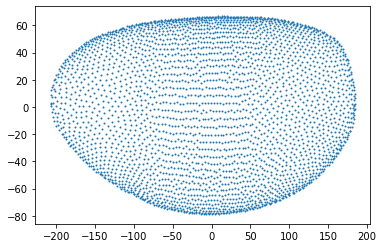

In [35]:
%matplotlib inline
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()


In [36]:
### Marker genes

In [37]:
insitu_matrix = pd.read_csv(datafile_atlas,sep="\t")
insitu_genes  = insitu_matrix.columns
atlas_matrix  = novosparc.io.load_data(datafile_atlas)
print("list of landmarks:",insitu_genes)
insitu_matrix.shape

list of landmarks: Index(['aay', 'Ama', 'Ance', 'Antp', 'apt', 'Blimp-1', 'bmm', 'bowl', 'brk',
       'Btk29A', 'bun', 'cad', 'CenG1A', 'CG10479', 'CG11208', 'CG14427',
       'CG17724', 'CG17786', 'CG43394', 'CG8147', 'cnc', 'croc', 'Cyp310a1',
       'D', 'dan', 'danr', 'Dfd', 'disco', 'Doc2', 'Doc3', 'dpn', 'edl', 'ems',
       'erm', 'Esp', 'E(spl)m5-HLH', 'eve', 'exex', 'fj', 'fkh', 'ftz', 'gk',
       'gt', 'h', 'hb', 'hkb', 'htl', 'Ilp4', 'ImpE2', 'ImpL2', 'ken', 'kni',
       'knrl', 'Kr', 'lok', 'Mdr49', 'Mes2', 'MESR3', 'mfas', 'Nek2', 'NetA',
       'noc', 'nub', 'numb', 'oc', 'odd', 'peb', 'prd', 'pxb', 'rau', 'rho',
       'run', 'sna', 'srp', 'tkv', 'tll', 'toc', 'Traf4', 'trn', 'tsh', 'twi',
       'zen', 'zen2', 'zfh1'],
      dtype='object')


(3039, 84)

In [38]:
insitu_matrix = insitu_matrix.loc[:,insitu_genes.intersection(data.index)]
insitu_matrix.shape

(3039, 84)

Visualize the expression of some marker genes : 


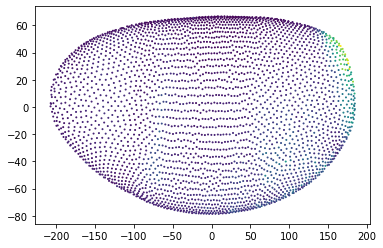

In [39]:
plt.scatter(locations[:, 0], locations[:, 1], c=insitu_matrix.loc[:,'aay'], s=1)


# 3. Predict the spatial transcriptome

**Principle of novosparc** (if no landmarks genes are provided) : 

1. construct a k-nearest neighbors (knn) graph 

    * for the physical space (cellular location) : calculate the (euclidian) distance matrix between the  locations, then for each location only keep the k-nearest neighbours (the value k is set by *num_neighbors_s*). 
    * for the expression space (single cells) : calculate the distance (correlation)  matrix between the  each cells, then for each location only keep the k-nearest neighbours (the value k is set by *num_neighbors_t*)

2. Novosparc compute the shortest path lengths for each pair of cells, resulting in graph-based distance matrices for cells and for locations. 

3. To to match the N single cells to the M position using these graphs, the algorithm try to minimize the discrepancy between the pair-wise graph-based distances in expression space and in physical space


## Predict the spatial transcriptome (without landmark genes)
Once you have defined the cellular locations, you can create a "tissue object" that will contain the predited spatial transcriptome.

In [47]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations,output_folder="outputs")
tissue.setup_reconstruction(num_neighbors_s = 5, num_neighbors_t = 5)   # compute the knn graphs                         


Setting up for reconstruction ... done ( 4.48 seconds )


Now we can reconstruct our tissue. The alpha_linear parameter controls the contribution of the two branches in novoSpaRc: alpha_linear=0 means that no prior information is available.


In [48]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 1297 cells and 3039 locations ... 
It.  |Err         
-------------------
    0|3.097168e-04|


In [49]:
print("number of cellular locations: ", tissue.num_locations)
print("number of single cells used for reconstruction: ", tissue.num_cells)
print("number of landmark markers used for reconstruction: ", tissue.num_markers)

number of cellular locations:  3039
number of single cells used for reconstruction:  1297
number of landmark markers used for reconstruction:  0


We store the spatial gene expression matrix (sDGE) for the highly variable genes across all locations in a new variable

## Analyse the results 
### Identify spatially informative genes : 
Novosparc use Moran's statistics to order the genes. Moran's statistics is a measure of spatial autocorrelation (values range from −1 to 1, and a value close to 0 indicates random spatial expression).

In [50]:
tissue.calculate_spatially_informative_genes()


Setting up Morans I analysis for 491 genes...done ( 140.87 seconds )
List of spatially_informative_genes  ['Peritrophin-A' 'Elba2' 'Ptp99A' 'CG1402' 'cno' 'Scp2' 'CHES-1-like'
 'CG42788' 'numb' 'Pvf3']


In [54]:
list_inform= tissue.spatially_informative_genes
print("List of spatially_informative_genes ", list_inform)

List of spatially_informative_genes  ['Peritrophin-A' 'Elba2' 'Ptp99A' 'CG1402' 'cno' 'Scp2' 'CHES-1-like'
 'CG42788' 'numb' 'Pvf3']


## Vizualise the predicted patterns 
We create a dataframe with the predicted pattern (genes in rows, predicted expression in each positon in columns) : 

In [52]:
df_wo_markers = pd.DataFrame(tissue.sdge,index=tissue.gene_names)
df_wo_markers.shape

(491, 3039)

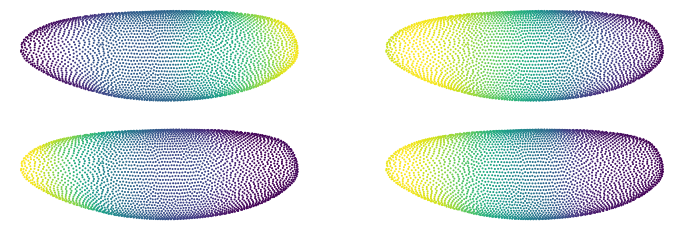

In [55]:
df_wo_markers.shape
plt.figure(figsize=(12,4))
plt.subplot(221)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc[list_inform[0], :], s=1)
plt.axis('off')
plt.subplot(222)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc[list_inform[1], :], s=1)
plt.axis('off')
plt.subplot(223)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc[list_inform[2], :], s=1)
plt.axis('off')
plt.subplot(224)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc[list_inform[3], :], s=1)
plt.axis('off')
plt.show()
plt.close()

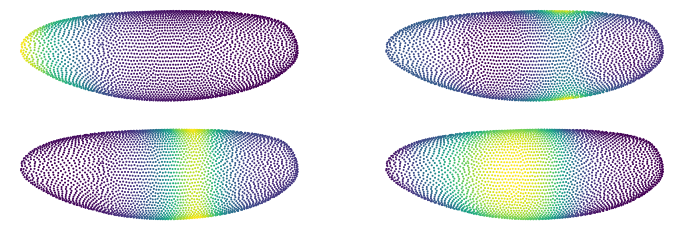

In [58]:
df_wo_markers.shape
plt.figure(figsize=(12,4))
plt.subplot(221)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc['zen', :], s=1)
plt.axis('off')
plt.subplot(222)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc['ImpE2', :], s=1)
plt.axis('off')
plt.subplot(223)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc['sim', :], s=1)
plt.axis('off')
plt.subplot(224)
plt.scatter(locations[:, 0], locations[:, 1], c=df_wo_markers.loc['pyr', :], s=1)
plt.axis('off')
plt.show()
plt.close()

This reconstruction has been realised without prior information. We can greatly improve the prediction by adding landmark genes

## Predict the spatial transcriptome (with landmark genes)

We are going to apply the same algorithm but this time we will use the landmarks genes.

In [59]:
tissue_with_markers = novosparc.cm.Tissue(dataset=dataset, locations=locations, atlas_matrix= insitu_matrix)

TypeError: __init__() got an unexpected keyword argument 'atlas_matrix'

First, we find the indices of the marker genes in the scRNAseq dataset

In [ ]:
gene_names = tissue_with_markers.gene_names
markers_in_sc = np.array([], dtype='int') # indice marker dans table sc

for marker in insitu_genes:
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
markers_in_sc

In [ ]:
tissue_with_markers.setup_reconstruction(markers_to_use=markers_in_sc,num_neighbors_s = 5, num_neighbors_t = 5)   # compute the knn graphs                         
alpha_linear = 0.5
tissue_with_markers.reconstruct(alpha_linear=0.5, epsilon=5e-3)

In [ ]:
print("number of cellular locations: ", tissue_with_markers.num_locations)
print("number of single cells used for reconstruction: ", tissue_with_markers.num_cells)
print("number of landmark markers used for reconstruction: ", tissue_with_markers.num_markers)

Exercice : optimize the reconstruction

* Try different values for `alpha_linear` (from 0 to 1)  and choose the best reconstruction.  


Other parameters to tune : 
* the number of neighbours :`num_neighbors_s` and `num_neighbors_t` in `setup_reconstruction`
* the list of markers genes used: select only some of the amrkers genes availables, and keep the other to validate your prediction.
